In [8]:
#!jt -r
# from jupyterthemes import jtplot
# jtplot.style()

In [9]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import pickle

# PATH
import sys
sys.path.append('../')
from lib.pod import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':20})
DPI = 60

#GLOBALS
VKS_DIR = '../data/VKS.pkl'
KPP_DIR = '../data/KPP.npz'
EE_DIR = '../data/EulerEqs.npz'
FIB_DIR = '../data/FiberData.dat'

# Von Karman Vortex Stream

*LOAD DATA*

In [10]:
with open(VKS_DIR, 'rb') as f:
    vks = pickle.load(f)
vks = np.nan_to_num(vks)
print('Data Shape: {}'.format(vks.shape))

Data Shape: (505, 279, 400, 3)


In [11]:
def vks_plot(vks_t):
    plt.figure(figsize=(16, 6), dpi=80)
    plt.subplot(131)
    plt.imshow(vks[:,:,vks_t,0])
    plt.title('Velocity in X direction')
    
    plt.subplot(132)
    plt.imshow(vks[:,:,vks_t,1])
    plt.title('Velocity in Y direction')

    plt.subplot(133)
    plt.imshow(vks[:,:,vks_t,2])
    plt.title('Density?')

interact_manual(vks_plot, vks_t = widgets.IntSlider(value=100,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=100, description='vks_t', max=399), Button(description='Run Interact', s…

<function __main__.vks_plot(vks_t)>

In [12]:
s_ind = 0
e_ind = vks.shape[2]
pod_modes = 4
spatial_modes, data_ROM, eigenvalues, Ux_LES, Uy_LES = POD2(vks, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (400, 4)


In [13]:
def vks_fullReduced(vks_t):

    data_x = vks[:,:,:,0].swapaxes(0,2)[100:,:]
    data_y = vks[:,:,:,1].swapaxes(0,2)[100:,:]

    pod_x = Ux_LES
    pod_y = Uy_LES

    plt.figure(figsize=(10,10), tight_layout=True)
    plt.subplot(221)
    plt.imshow(data_x[vks_t,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('FOM U_x')
    plt.subplot(222)
    plt.imshow(pod_x[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_x')
    plt.subplot(223)
    plt.imshow(data_y[vks_t,:,:].T, origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('FOM U_y')
    plt.subplot(224)
    plt.imshow(pod_y[vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_y')

interact_manual(vks_fullReduced, vks_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='vks_t', max=399), Button(description='Run Interact', sty…

<function __main__.vks_fullReduced(vks_t)>

*PLOT 100 TIME STEPS*

No handles with labels found to put in legend.


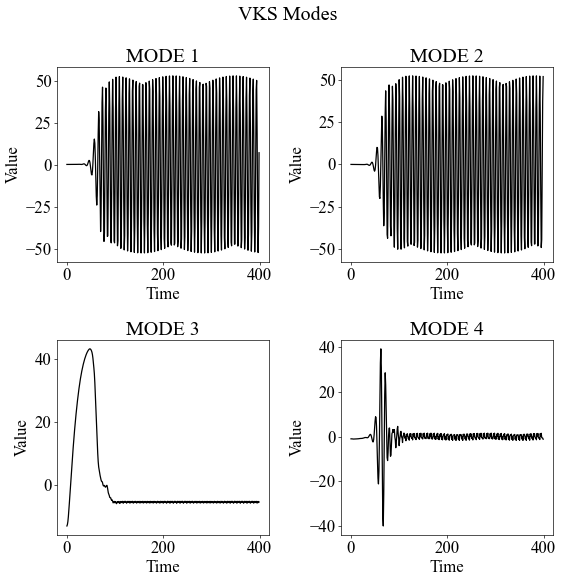

In [14]:
m=2
n = pod_modes//m
plt.figure(figsize=(5*pod_modes//2,10), tight_layout=True, dpi=DPI)
plt.suptitle("VKS Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data_ROM[:,i], 'k')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/VKS/podModes.pdf', format="pdf", bbox_inches="tight")


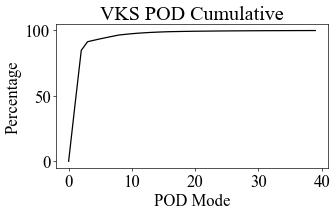

In [15]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[0]

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [val+cumulative[-1]]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("VKS POD Cumulative")
plt.plot(x2,cumulative, 'k')
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/VKS/podCumulative.pdf', format="pdf", bbox_inches="tight")

In [16]:
Nxy = vks.shape[0]*vks.shape[1]
pod_true = np.matmul(data_ROM, spatial_modes.T)
pod_x = pod_true[:, :Nxy]
pod_y = pod_true[:, Nxy:]

shape = [pod_true.shape[0], vks.shape[0], vks.shape[1]]

pod_x = pod_x.reshape(shape[0], shape[1], shape[2])
pod_y = pod_y.reshape(shape[0], shape[1], shape[2])

In [17]:
def vks_Reconstructed(rec_vks_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    plt.subplot(221)
    plt.imshow(pod_x[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_x')

    plt.subplot(222)
    plt.imshow(vks[:,:,rec_vks_t,0], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('True U_x')

    plt.subplot(223)
    plt.imshow(pod_y[rec_vks_t,:,:], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('ROM U_y')

    plt.subplot(224)
    plt.imshow(vks[:,:,rec_vks_t,1], origin='upper', cmap='jet', vmin =-.4, vmax = .4)
    plt.title('True U_y')

interact_manual(vks_Reconstructed, rec_vks_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=vks.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='rec_vks_t', max=399), Button(description='Run Interact',…

<function __main__.vks_Reconstructed(rec_vks_t)>

# KPP Equations

In [45]:
npdata = np.load(KPP_DIR)
xv, yv, kpp = npdata['arr_0'], npdata['arr_1'], npdata['arr_2']
print('Data Shape: {}'.format(kpp.shape))
end = kpp.shape[2]

Data Shape: (20, 20, 501)


In [46]:
def kpp_plot(kpp_t):
    plt.figure(figsize=(16, 6), dpi=80)
    ax = plt.axes(projection='3d')
    ax.plot_surface(xv, yv, kpp[:,:,kpp_t], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.legend()
    plt.title('Density $\\rho$')
    
interact_manual(kpp_plot, kpp_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=end-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='kpp_t', max=500), Button(description='Run Interact', sty…

<function __main__.kpp_plot(kpp_t)>

In [47]:
s_ind = 0
e_ind = end
pod_modes = 4
#spatial_modes, data_ROM, eigenvalues, Ux_LES = POD1(np.nan_to_num(rho[:,:,1]).T, s_ind, e_ind, pod_modes)
spatial_modes, data_ROM, eigenvalues, Ux_LES= PODKPP(kpp, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (501, 4)


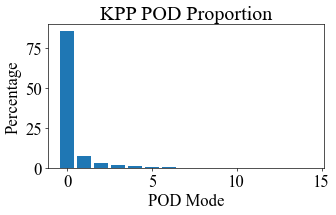

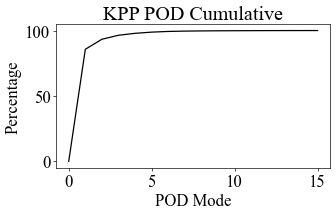

In [48]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[0]

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [val+cumulative[-1]]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#PERCENTAGE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("KPP POD Proportion")
plt.bar(x,data)
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/KPP/podPercentage.pdf', format="pdf", bbox_inches="tight")
#CUMULATIVE PLOT
#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("KPP POD Cumulative")
plt.plot(x2,cumulative, 'k')
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/KPP/podCumulative.pdf', format="pdf", bbox_inches="tight")

No handles with labels found to put in legend.


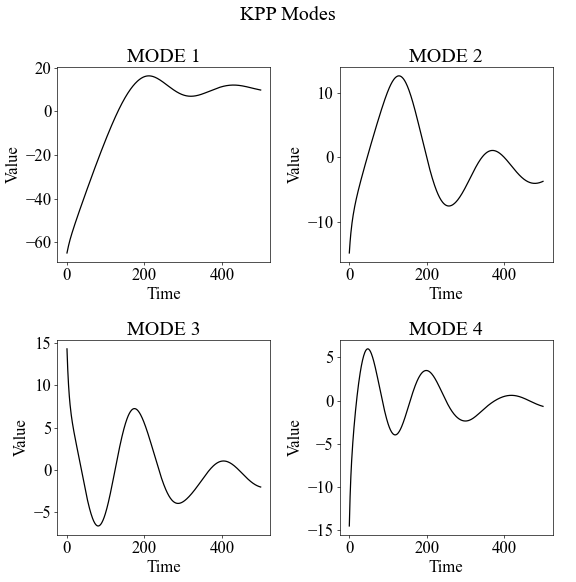

In [49]:
m=2
n = pod_modes//m
plt.figure(figsize=(5*pod_modes//2,10), tight_layout=True, dpi=DPI)
plt.suptitle("KPP Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data_ROM[:,i], 'k')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/KPP/podModes.pdf', format="pdf", bbox_inches="tight")

In [50]:
Nx = kpp.shape[0]
Ny = kpp.shape[1]
pod_true = np.matmul(data_ROM, spatial_modes.T)
shape = pod_true.shape[0]

pod_true = pod_true.reshape(shape, Nx, Ny)

In [51]:
def kpp_Reconstructed(rec_kpp_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    ax1 = plt.subplot(221, projection='3d')
    ax1.plot_surface(xv, yv, pod_true[rec_kpp_t,:,:], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax1.set_title('ROM h(x)')

    ax2 = plt.subplot(222, projection='3d')
    ax2.plot_surface(xv, yv, kpp[:,:,rec_kpp_t], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax2.set_title('True h(x)')

interact_manual(kpp_Reconstructed, rec_kpp_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=kpp.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='rec_kpp_t', max=500), Button(description='Run Interact',…

<function __main__.kpp_Reconstructed(rec_kpp_t)>

# Euler Equations

In [52]:
npzdata = np.load(EE_DIR)
param = 50
rho, u, E, x, params, t = npzdata['arr_0'], npzdata['arr_1'], npzdata['arr_2'], npzdata['arr_3'], npzdata['arr_4'], npzdata['arr_5']
ee = np.array([rho[:,:,param], u[:,:,param], E[:,:,param]])
print('Data Shape: {}'.format(ee.shape))
print(x.shape, rho.shape)
end = ee.shape[2]

Data Shape: (3, 500, 626)
(500,) (500, 626, 100)


In [53]:
def ee_plot(ee_t1, ee_p1, ee_t2, ee_p2):
    plt.figure(figsize=(16, 6), dpi=80)
    plt.subplot(131)
    plt.plot(x, rho[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, rho[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.legend()
    plt.title('Density $\\rho$')
    
    plt.subplot(132)
    plt.plot(x, u[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, u[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.title('Velocty $u$')
    plt.xlabel('$x$')

    plt.subplot(133)
    plt.plot(x, E[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, E[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.title('Energy $E$')
    plt.xlabel('$x$')

interact_manual(ee_plot, ee_t1 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=len(t)-1,
                                               step=1),
                     ee_p1 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=100-1,
                                               step=1),
                     ee_t2 = widgets.IntSlider(value=20,
                                               min=0,
                                               max=len(t)-1,
                                               step=1),
                    ee_p2 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=100-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='ee_t1', max=625), IntSlider(value=0, description='ee_p1'…

<function __main__.ee_plot(ee_t1, ee_p1, ee_t2, ee_p2)>

In [54]:
s_ind = 0
e_ind = end
pod_modes = 4
#spatial_modes, data_ROM, eigenvalues, Ux_LES = POD1(np.nan_to_num(rho[:,:,1]).T, s_ind, e_ind, pod_modes)
spatial_modes, data_ROM, eigenvalues, Ux_LES, Uy_LES, Uz_LES = POD3(np.nan_to_num(ee), s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (626, 4)


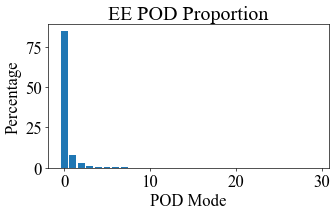

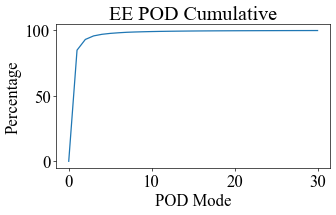

In [21]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[0]

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [val+cumulative[-1]]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#PERCENTAGE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("EE POD Proportion")
plt.bar(x,data)
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/EE/podPercentage.pdf', format="pdf", bbox_inches="tight")
#CUMULATIVE PLOT
#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("EE POD Cumulative")
plt.plot(x2,cumulative)
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/EE/podCumulative.pdf', format="pdf", bbox_inches="tight")

No handles with labels found to put in legend.


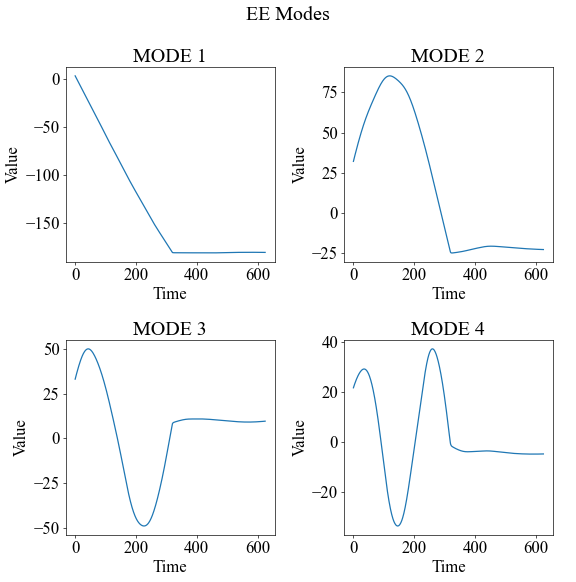

In [22]:
m=2
n = pod_modes//m
plt.figure(figsize=(5*pod_modes//2,10), tight_layout=True, dpi=DPI)
plt.suptitle("EE Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data_ROM[:,i])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/EE/podModes.pdf', format="pdf", bbox_inches="tight")


In [23]:
s_ind = 0
e_ind = 5000
pod_modes = 20
spatial_modes, data_ROM, eigenvalues, Ux_LES = POD1(np.nan_to_num(rho[:,:,1]).T, s_ind, e_ind, pod_modes)
#spatial_modes, data_ROM, eigenvalues, Ux_LES, Uy_LES, Uz_LES = POD3(np.nan_to_num(ee), s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (626, 20)


[51234.12021945 35296.98095501 18004.97087511 13362.16737585
  7591.54981619  6274.9195913   3444.34331557  2415.8539439
  2009.99091294  1447.56688725  1112.48616208  1028.06489317]


<BarContainer object of 58 artists>

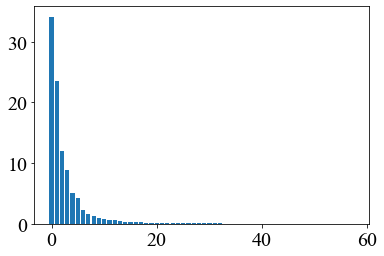

In [24]:
perc = 99.99
total = eigenvalues.sum()
data = []

print(eigenvalues[:12])

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]

x_ = np.arange(0,len(data))

plt.figure()
plt.bar(x_,data)

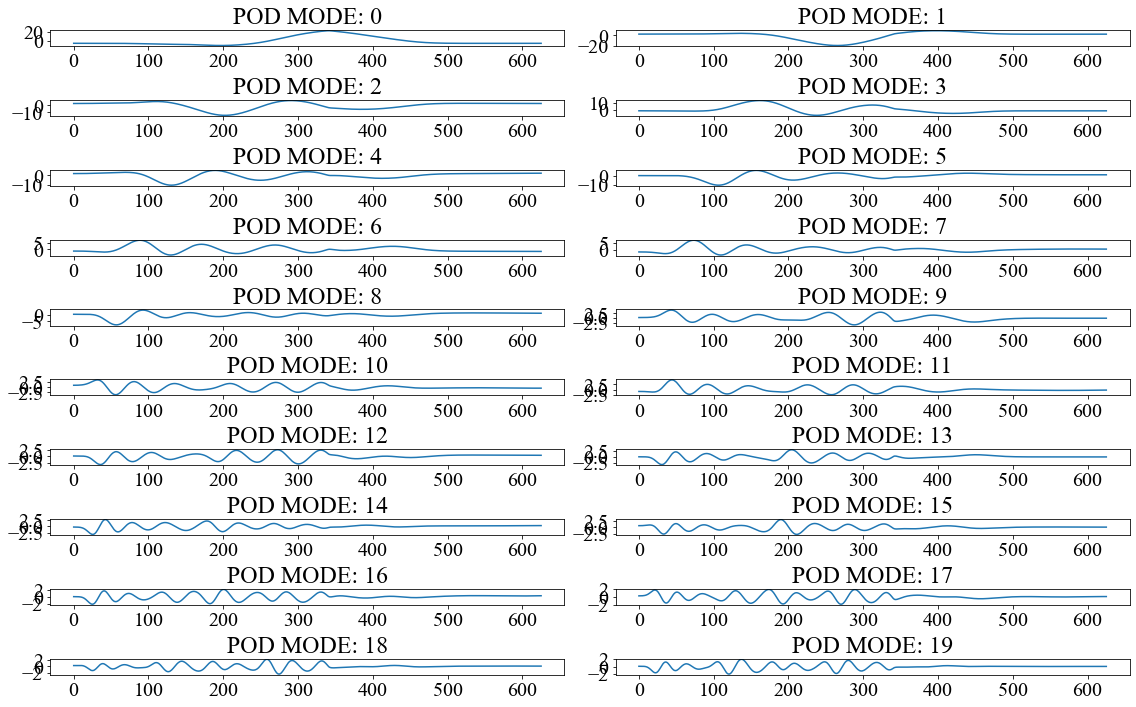

In [25]:
m=2
n = pod_modes//m
fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(16,10))
fig.tight_layout()
for i,ax in enumerate(axs):
    for j in range(m):
        ax[j].plot(data_ROM[:,i*m+j])
        ax[j].set_title('POD MODE: {}'.format(i*m+j))

In [26]:
pod_true = np.matmul(data_ROM, spatial_modes.T)
print(pod_true.shape)

(626, 500)


In [27]:
def ee_Reconstructed(rec_ee_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    plt.subplot(121)
    plt.plot(pod_true[rec_ee_t,:])
    plt.title('ROM h(x)')

    plt.subplot(122)
    plt.plot(rho[:,rec_ee_t,param])
    plt.title('True h(x)')

interact_manual(ee_Reconstructed, rec_ee_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=ee.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='rec_ee_t', max=625), Button(description='Run Interact', …

<function __main__.ee_Reconstructed(rec_ee_t)>

# Fiber
*LOAD DATA*

In [28]:
fiber = pd.read_table(FIB_DIR, sep="\t", index_col=2, names=["x", "h"]).to_numpy()
m = fiber.shape[0]//401
x = fiber[:,0].reshape(m,401)
fiber = fiber[:,1].reshape(m,401)
print(fiber.shape)

(426, 401)


In [29]:
def fib_plot(fib_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = fiber[fib_t, :]
    plt.plot(y)
    plt.ylim((0,1))
    plt.title('Height along the rod at time {}'.format(fib_t))
    
interact(fib_plot, fib_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fib_t', max=425), Output()), _dom_classes=('widget-inter…

<function __main__.fib_plot(fib_t)>

In [30]:
s_ind = 0
e_ind = fiber.shape[0]
pod_modes = 12
spatial_modes, data_ROM, eigenvalues, Ux_rom = POD1(fiber, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))


REDUCED MODEL SHAPE: (426, 12)


[3.06951315e+03 2.93332834e+03 8.69553464e+02 8.21023313e+02
 6.66149232e+01 4.57597947e+01 4.38197519e+01 9.56338864e+00
 9.29750287e+00 3.07583424e+00 2.99895789e+00 7.69026350e-01]


<BarContainer object of 11 artists>

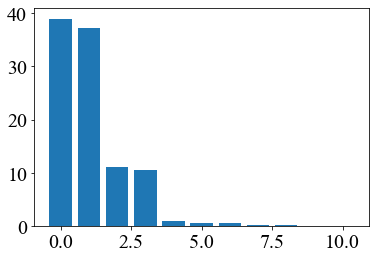

In [31]:
perc = 99.99
total = eigenvalues.sum()
data = []

print(eigenvalues[:12])

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]

x = np.arange(0,len(data))

plt.figure()
plt.bar(x,data)

In [32]:
def fibRom_plot(fibRom_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = Ux_rom[fibRom_t, :]
    plt.ylim((-.5,.5))
    plt.plot(y)
    plt.title('Height along the rod at time {}'.format(fibRom_t))
    
interact(fibRom_plot, fibRom_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fibRom_t', max=425), Output()), _dom_classes=('widget-in…

<function __main__.fibRom_plot(fibRom_t)>

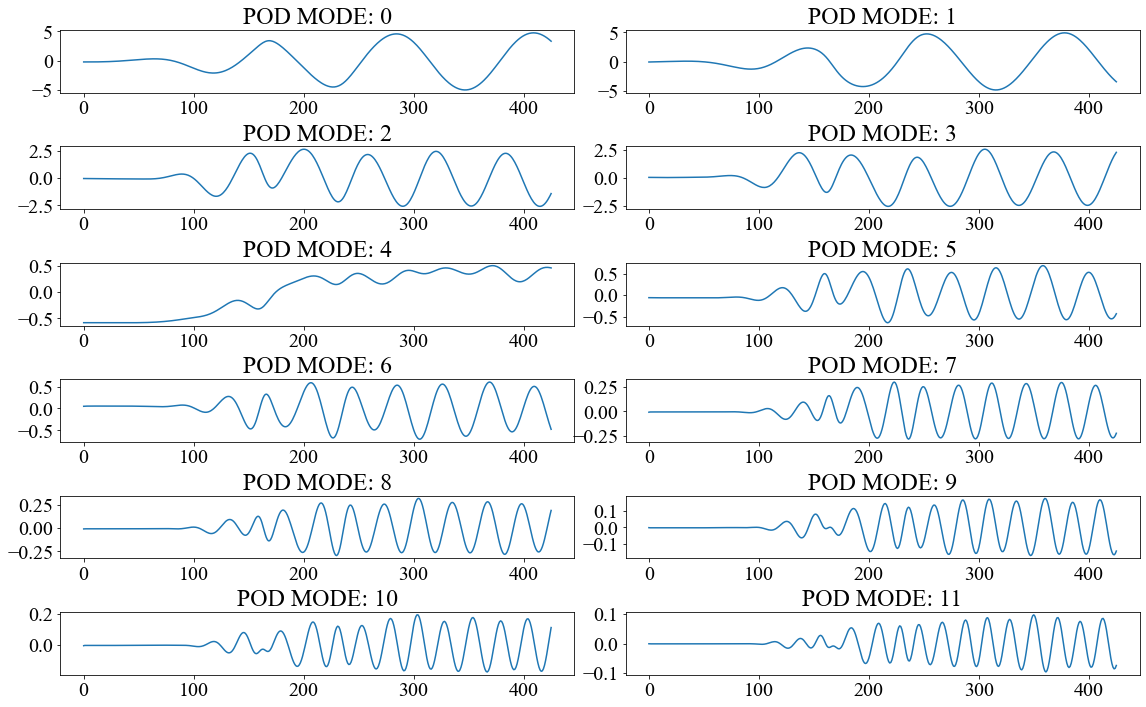

In [33]:
m=2
n = pod_modes//m
fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(16,10))
fig.tight_layout()
#double check
for i,ax in enumerate(axs):
    for j in range(m):
        ax[j].plot(data_ROM[:,i*m+j])
        ax[j].set_title('POD MODE: {}'.format(i*m+j))

In [34]:
pod = np.matmul(data_ROM, spatial_modes.T)
def fibPod_plot(fibPod_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = pod[fibPod_t, :]
    plt.plot(y)
    plt.title('Height along the rod at time {}'.format(fibPod_t))
    
interact(fibPod_plot, fibPod_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fibPod_t', max=2), Output()), _dom_classes=('widget-inte…

<function __main__.fibPod_plot(fibPod_t)>